# SLACS sample selection
This notebook contains the sample selection from the SLACS lenses.

In [1]:
from lenstronomy.Util import constants as const
from hierarc.Diagnostics.goodness_of_fit import GoodnessOfFit
import numpy as np
import pickle
from astropy.io import fits
from os.path import dirname, abspath
import os
import copy
import csv
import corner
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from pylab import rc

rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

path2Analysis = dirname(abspath(os.getcwd()))

path2tdcosmo = 'TDCOSMO_sample'
path2slacs = 'SLACS_sample'
path2kappa = os.path.join(path2Analysis, path2slacs, 'kappaSLACS')

file_name_slacs = os.path.join(path2Analysis, path2slacs, 'slacs_all_params.csv')
file_name_tdcosmo = os.path.join(path2Analysis, path2tdcosmo, 'tdcosmo_sample.csv')

file_name_slacs_los = os.path.join(path2Analysis, path2slacs, 'LineOfSightData.csv')

slacs_processed_file = 'slacs_slit_om_processed.pkl'

# file containing different measurements of the stellar kinematics of the SLACS lenses
v_disp_file_name = 'vdisp_slacs_asb.fits'
v_disp_file = os.path.join(path2Analysis, path2slacs, v_disp_file_name)
HDU = fits.open(v_disp_file)
vel_disp_data = HDU[1].data

In [2]:
# add path to SLACS


H0 = 73
omega_m = 0.30
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
cosmo = FlatLambdaCDM(H0=H0, Om0=omega_m)

In [3]:
NoverRmed_random = 1.028768  # N/r value from 100000 random patches on the sky with same survey and depth as the lenses

def NoverRmed(name):
    """
    reads out the number for N/r weigthing from the DECals data in the table for a specific lens
    """
    with open(file_name_slacs_los, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if '#name' in row:
                name_row = row['#name']
                if name_row == name:
                    return float(row['NoverRmed']) / NoverRmed_random
    print('lens with name %s not in table.' % (name))
    return -1

def vel_disp(name, row):
    """
    reads out the velocity dispersion and error from the fits file. Table from Yiping Shu with products by Adam Bolton
    """
    for lens in vel_disp_data:
        if name == lens['SDSS_NAME']:
            sigma = lens['VDISP_ASB']
            if sigma > 0:
                return lens['VDISP_ASB'], lens['VDISP_ASB_ERR']
            #else:
            #    print('no measured dispersion from tabel' )
    #print('name %s not in sample  - using SDSS standard reduction' % (name))
    return float(row['sigma_v']), float(row['sigma_v_error'])

def select_lenses(file_name, ifu_select=False, imaging_flag_select=False, 
                  ifu_flag_select=False, z_lens_min=0, 
                  sigma_v_min=100, sigma_v_max=400,
                  r_eff2theta_E_max=20, NoverRmed_max=1.78):
    """
    z_lens, z_source, sigma_v, r_eff, theta_E, gamma
    """
    lens_list = []
    name_list = []

    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name = row['name']
            nR_med = NoverRmed(name)
            sigma_v, sigma_v_error = vel_disp(name, row)
            sigma_v = float(row['sigma_v'])
            lensCosmo = LensCosmo(float(row['z_lens']), float(row['z_source']), cosmo=cosmo)
            sigma_v_SIS = lensCosmo.sis_theta_E2sigma_v(float(row['theta_E']))
            select_lens = False
            imaging_flag = float(row.get('flag_imaging', 1))
            perturber_flag = float(row.get('perturber_flag', 1))
            if imaging_flag == 1:
                gamma = float(row['gamma'])
            else:
                gamma = -1  # sample mean power-law slope
            if not imaging_flag_select and imaging_flag >= 0:
                imaging_flag = 1
            
            if ifu_flag_select:
                if 'flag_ifu' in row:
                    try:
                        ifu_flag = float(row['flag_ifu'])
                    except:
                        ifu_flag = 1
                else:
                    ifu_flag = 1
            else:
                ifu_flag = 1
            if float(row['z_lens']) > z_lens_min and imaging_flag == 1 and ifu_flag == 1:
                if ifu_select:
                    if float(row['IFU']) == 1 and ifu_flag == 1:
                        select_lens = True
                else:
                    if 'IFU' in row:
                        if float(row['IFU']) != 1:
                            select_lens = True
                    else:
                        select_lens = True
            if sigma_v_SIS > sigma_v_max or sigma_v_SIS < sigma_v_min:
                select_lens = False
                
            if float(row['r_eff'])/float(row['theta_E']) >r_eff2theta_E_max:
                select_lens = False
            if imaging_flag < 0:
                select_lens = False
            if nR_med > NoverRmed_max:
                select_lens = False
            if select_lens and perturber_flag:
                lens_list.append([float(row['z_lens']), float(row['z_source']), sigma_v, float(row['r_eff']), float(row['theta_E']), float(row['r_eff'])/float(row['theta_E']), gamma, sigma_v_SIS]) #, nR_med])  # , sigma_v_predict/sigma_v
                name_list.append(name)
            if perturber_flag is True and nR_med < NoverRmed_max:
                print('lens %s has perturber nearby but meats the NoverRmed criteria >%s with %s' % (name, NoverRmed_max, nR_med))
    return np.array(lens_list), name_list


In [4]:

labels = [r"$z_{\rm lens}$", r"$z_{\rm source}$", r"$\sigma^{\rm P}$[km/s]", r'$r_{\rm eff}$[arcsec]', r'$\theta_{\rm E}$[arcsec]', r'$r_{\rm eff}/\theta_{\rm E} $', r"$\gamma_{\rm pl}$", r"$\sigma_{\rm SIS}$", r"$\xi_{N/r}$"]  # r"$\sigma_{\rm predict}/\sigma_{\rm measured}$", 
z_lens_min = 0. #0.01
sigma_v_min = 200  # 150
sigma_v_max = 350 # 350
NoverRmed_max = 2.16 / NoverRmed_random  # 2.16  # 1.78  # maximal median 1/r weighted relative number counts

kwargs_cut = {'sigma_v_min': sigma_v_min, 'sigma_v_max': sigma_v_max, 'z_lens_min': z_lens_min, 'r_eff2theta_E_max': 20, 'NoverRmed_max': NoverRmed_max}
slacs_ifu_sample_quality, slacs_ifu_names_quality = select_lenses(file_name_slacs, ifu_select=True, imaging_flag_select=True, ifu_flag_select=True, **kwargs_cut)
slacs_ifu_sample_all, slacs_ifu_names_all = select_lenses(file_name_slacs, ifu_select=True, imaging_flag_select=False, ifu_flag_select=True, **kwargs_cut)


#slacs_slit_sample, slacs_slit_names = select_lenses(file_name_slacs, ifu_select=False, imaging_flag_select=True, ifu_flag_select=False, z_lens_min=z_lens_min, sigma_v_min=190, sigma_v_max=330, r_eff2theta_E_max=10)
slacs_slit_sample_quality, slacs_slit_names_quality = select_lenses(file_name_slacs, ifu_select=False, imaging_flag_select=True, ifu_flag_select=False, **kwargs_cut)
slacs_slit_sample_all, slacs_slit_names_all = select_lenses(file_name_slacs, ifu_select=False, imaging_flag_select=False, ifu_flag_select=False, **kwargs_cut)
td_cosmo_sample, td_cosmo_names = select_lenses(file_name_tdcosmo, ifu_select=False)


/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/lens_cosmo.py:229: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v_sigma_c2)*const.c / 1000


lens with name B1608+656 not in table.
lens with name RXJ1131-1231 not in table.
lens with name HE0435-1223 not in table.
lens with name SDSS1206+4332 not in table.
lens with name WFI2033-4723 not in table.
lens with name PG1115+080 not in table.
lens with name DES0408-5354 not in table.


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


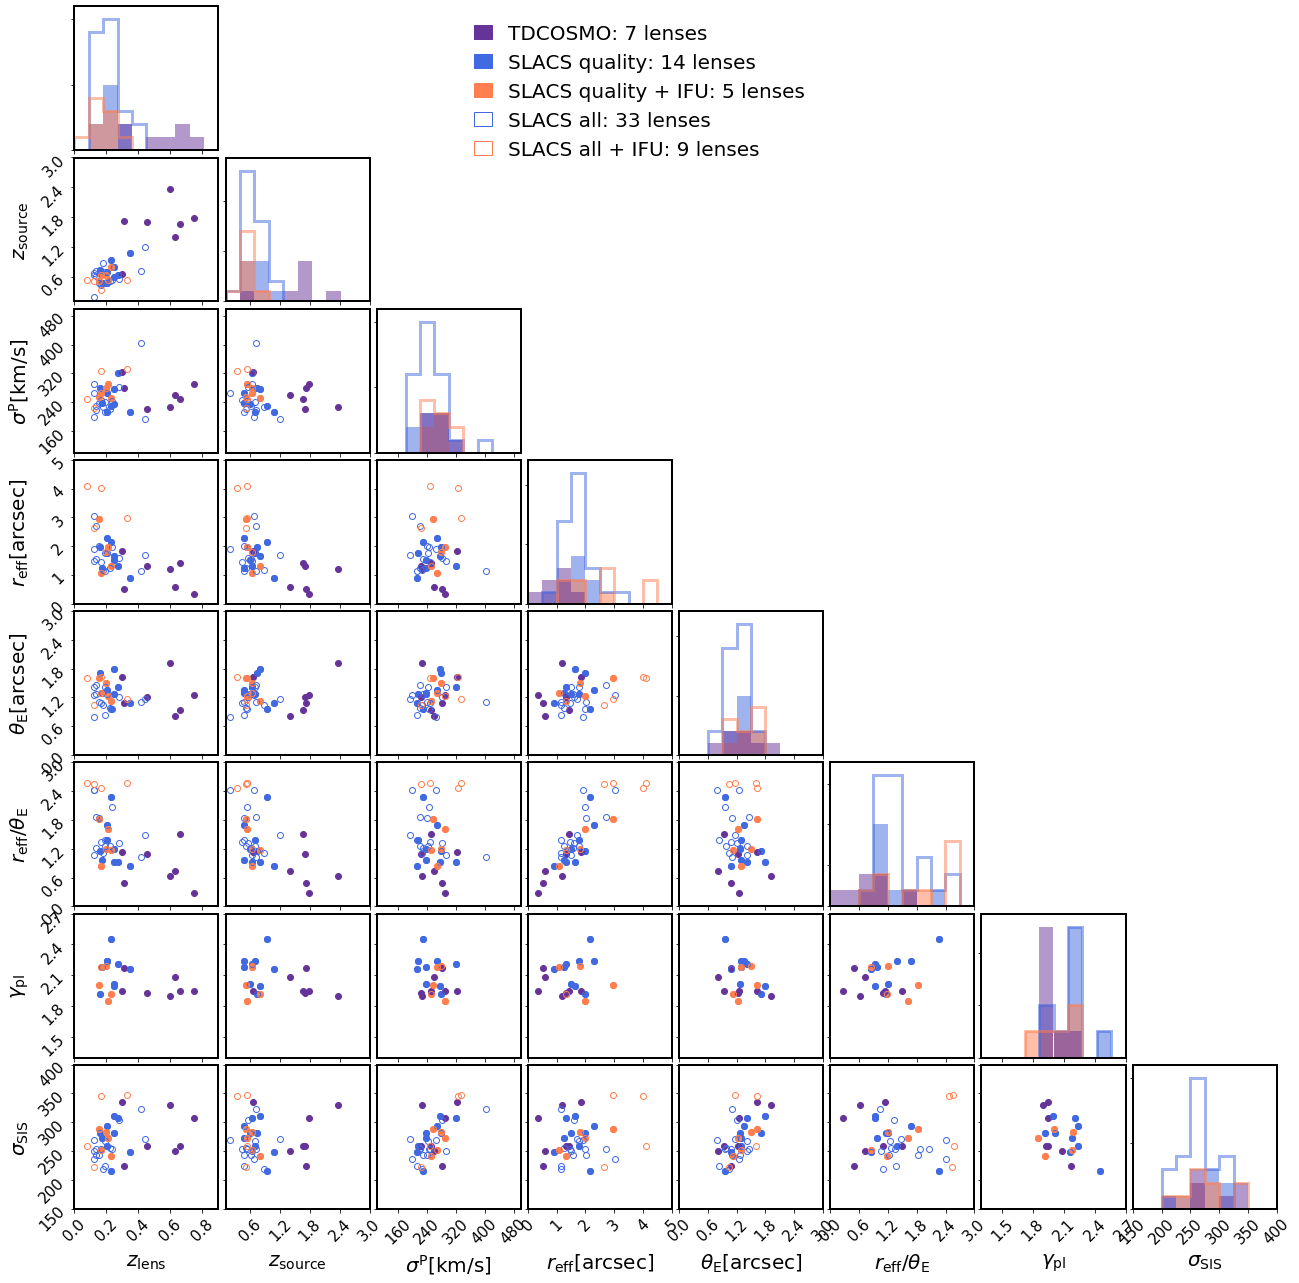

In [19]:
from myplots import triangle
color_list = ['royalblue', 'coral', 'rebeccapurple']
#color_list = ['g', 'r', 'b', 'm', 'b', 'g', 'k', 'r', 'purple', 'k']
extents = [[0, 0.9], [0.1, 3], [100, 500], [0., 5], [0, 3], [0, 3], [1.3, 2.7], [150, 400], [0, 5]]



fig, axes = triangle.corner_multi(xs_list=[slacs_slit_sample_quality, slacs_ifu_sample_quality, td_cosmo_sample], 
                      weights_list=None, labels=labels, fontsize=20, show_titles=False, title_fmt=".2f",
           title_args={}, extents=extents, truths=None, truth_color="#4682b4",
           scale_hist=False, quantiles=[], verbose=False, dots=None, hist1d_bool=True,
                 scatter_plot=True, kwargs_scatter={'marker': 'o', 'linestyle': ''},
                 cmap_list=["Blues", "Greens", "Oranges", "Reds", "BuPu", "binary"],
                 line_style_list = ['solid', 'solid', 'solid'],
                 color_list=color_list,
                 kwargs_hist2d={}, kwargs_hist1d={'linewidth': 3, 'density': False, 'histtype': "bar", 'alpha': 0.5, 'bins': 10})


fig, axes = triangle.corner_multi(xs_list=[slacs_slit_sample_all, slacs_ifu_sample_all], fig=fig, 
                      weights_list=None, labels=labels, fontsize=20, show_titles=False, title_fmt=".2f",
           title_args={}, extents=extents, truths=None, truth_color="#4682b4",
           scale_hist=False, quantiles=[], verbose=False, dots=None, hist1d_bool=True,
                 scatter_plot=True, kwargs_scatter={'marker': 'o', 'linestyle': '', 'markerfacecolor': 'none'},
                 cmap_list=["Blues", "Greens", "Oranges", "Reds", "BuPu", "binary"],
                 line_style_list = ['solid', 'solid', 'solid'],
                 color_list=color_list,
                 kwargs_hist2d={}, kwargs_hist1d={'linewidth': 3, 'density': False, 'histtype': "step", 'alpha': 0.5, 'bins': 10})


ax = axes[0,4]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


patch_1 = mpatches.Patch(color=color_list[2], label='TDCOSMO: ' + str(len(td_cosmo_sample)) + ' lenses')
patch_2 = mpatches.Patch(color=color_list[0], label='SLACS quality: ' + str(len(slacs_slit_sample_quality) + len(slacs_ifu_sample_quality)) + ' lenses')
patch_3 = mpatches.Patch(color=color_list[1], label='SLACS quality + IFU: ' + str(len(slacs_ifu_sample_quality)) + ' lenses')
patch_4 = mpatches.Patch(color=color_list[0], fill=False, label='SLACS all: ' + str(len(slacs_slit_sample_all) + len(slacs_ifu_sample_all)) + ' lenses')
patch_5 = mpatches.Patch(color=color_list[1], fill=False, label='SLACS all + IFU: ' + str(len(slacs_ifu_sample_all)) + ' lenses')


ax.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], fontsize=20, handlelength=0.9, loc=1, frameon=False)

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/sample_selection.pdf')
fig.show()



In [6]:
print(len(slacs_slit_names_all+slacs_ifu_names_all))
print(slacs_slit_names_all)
print(slacs_ifu_names_all)

33
['SDSSJ0008-0004', 'SDSSJ0029-0055', 'SDSSJ0044+0113', 'SDSSJ0330-0020', 'SDSSJ0728+3835', 'SDSSJ0959+4416', 'SDSSJ1016+3859', 'SDSSJ1020+1122', 'SDSSJ1023+4230', 'SDSSJ1112+0826', 'SDSSJ1134+6027', 'SDSSJ1142+1001', 'SDSSJ1153+4612', 'SDSSJ1213+6708', 'SDSSJ1218+0830', 'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1403+0006', 'SDSSJ1432+6317', 'SDSSJ1531-0105', 'SDSSJ1621+3931', 'SDSSJ1630+4520', 'SDSSJ1644+2625', 'SDSSJ2347-0005']
['SDSSJ0037-0942', 'SDSSJ0216-0813', 'SDSSJ0912+0029', 'SDSSJ1204+0358', 'SDSSJ1250+0523', 'SDSSJ1451-0239', 'SDSSJ1627-0053', 'SDSSJ2303+1422', 'SDSSJ2321-0939']


In [7]:

print(slacs_slit_names_quality)
print(slacs_ifu_names_quality)

['SDSSJ0029-0055', 'SDSSJ0330-0020', 'SDSSJ0728+3835', 'SDSSJ1112+0826', 'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1531-0105', 'SDSSJ1621+3931', 'SDSSJ1630+4520']
['SDSSJ0037-0942', 'SDSSJ1204+0358', 'SDSSJ1250+0523', 'SDSSJ1627-0053', 'SDSSJ2303+1422']


## line-of-sight selection function estimate


In [8]:
# lensing efficiency re-weighting
kappa_crit_slacs = []
for i in range(len(slacs_slit_sample_all)):
    z_lens = slacs_slit_sample_all[i, 0]
    z_source = slacs_slit_sample_all[i, 1]
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    kappa_crit_slacs.append(lensCosmo.sigma_crit)
    
kappa_crit_tdcosmo = []
for i in range(len(td_cosmo_sample)):
    z_lens = td_cosmo_sample[i, 0]
    z_source = td_cosmo_sample[i, 1]
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    kappa_crit_tdcosmo.append(lensCosmo.sigma_crit)

print('relative lensing efficiency between the SLACS and the TDCOSMO sample: ', np.mean(kappa_crit_slacs) / np.mean(kappa_crit_tdcosmo))


#td_cosmo_sample

ds_tdcosmo = cosmo.angular_diameter_distance(z=1.6)
ds_sdss = cosmo.angular_diameter_distance(z=0.6)
# scatter introduced by Dd?

relative lensing efficiency between the SLACS and the TDCOSMO sample:  1.6772374903601177


## sample distribution in power-law slope from imaging data (from Shajib et al. 2020)

mean $\gamma_{\rm pl}$:  2.1009051909932297
error in mean:  0.014642960185459476
1-sigma distribution width:  0.15942996176975885


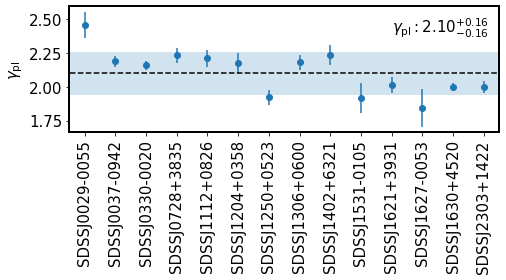

In [9]:
# we use all the quality lenses to estimate the sample mean in gamma and it's uncertainty
name_list_gamma = slacs_slit_names_quality+slacs_ifu_names_quality

def gamma_distribution(file_name, sample_names):
    """
    computes the sample mean in the power-law slope, the uncertainty in the mean and the spread
    """
    num_sample = len(sample_names)
    gamma_mean_list = []
    gamma_sigma_list = []
    gamma_name_list = []
    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name = row['name']
            if name in sample_names:
                gamma_mean_list.append(float(row['gamma']))
                gamma_sigma_list.append(float(row['gamma_error']))
                gamma_name_list.append(name)
    gamma_mean_list = np.array(gamma_mean_list)
    gamma_sigma_list = np.array(gamma_sigma_list)
                
    gamma_mean = np.sum(gamma_mean_list / gamma_sigma_list**2) / np.sum(1./ gamma_sigma_list**2)
    gamma_mean_sigma = np.sqrt(1 / np.sum(1./ gamma_sigma_list**2)) * num_sample / (num_sample - 1)
    gamma_sigma = np.std(gamma_mean_list)
    return gamma_mean, gamma_mean_sigma, gamma_sigma, gamma_mean_list, gamma_sigma_list, gamma_name_list


gamma_mean, gamma_mean_sigma, gamma_sigma, gamma_mean_list, gamma_sigma_list, gamma_name_list = gamma_distribution(file_name_slacs, name_list_gamma)

print(r'mean $\gamma_{\rm pl}$: ', gamma_mean)
print('error in mean: ', gamma_mean_sigma)
print('1-sigma distribution width: ', gamma_sigma)

title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".2f").format

txt = r'$\gamma_{\rm pl}: $' + title.format(fmt(gamma_mean), fmt(gamma_sigma), fmt(gamma_sigma))

f, ax = plt.subplots(1, 1, figsize=(len(gamma_mean_list)/2, 4))
ax.errorbar(np.arange(len(gamma_mean_list)), gamma_mean_list, yerr=gamma_sigma_list, xerr=None, fmt='o', ecolor=None, elinewidth=None,
            capsize=None, barsabove=False, lolims=False, uplims=False,
            xlolims=False, xuplims=False, errorevery=1, capthick=None, data=None, label=None)
ax.set_xticks(ticks=np.arange(len(gamma_mean_list)))
ax.set_xticklabels(labels=gamma_name_list, rotation='vertical')
ax.set_ylabel(r'$\gamma_{\rm pl}$', fontsize=15)
ax.hlines(gamma_mean, xmin=-1, xmax=len(gamma_mean_list), colors='k', linestyles='--')
ax.fill_between([-1, len(gamma_mean_list)], gamma_mean - gamma_sigma, gamma_mean + gamma_sigma, alpha=0.2)
ax.set_xlim([-0.5, len(gamma_mean_list)-0.5])
ax.text(10, 2.4, txt, fontsize=15)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/gamma_pl_slacs.pdf')

plt.show()

## $\kappa_{\rm ext}$ distributions

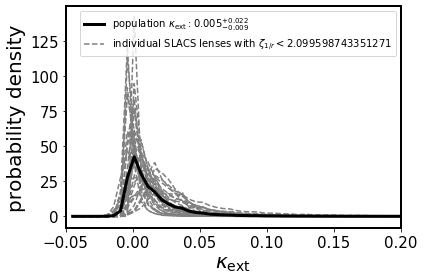

In [10]:
from hierarc.Util.distribution_util import PDFSampling

names_selected = slacs_slit_names_all + slacs_ifu_names_all

percentiles = [16, 50, 84]
quantiles = [0.16, 0.5, 0.84]
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".3f").format

# option with file ending
with_shear = False  # bool, if True, adds shear constraints in LOS estimate (only available for a subset of the sample)

kappa_choice_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_23.0_med_increments2_16_2_emptymsk_shearwithoutprior.cat'
kappa_choice_no_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat'

if with_shear is True:
    kappa_choice_ending = kappa_choice_shear_ending
else:
    kappa_choice_ending = kappa_choice_no_shear_ending
    
    
kappa_bins = np.linspace(-0.05, 0.2, 50)

# loop through selected lenses

kappa_pdf_tot = np.zeros(len(kappa_bins)-1)
num_lenses = 0

for name in names_selected:
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
 
    try:
        output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True) #, bins=kappa_bins
        kappa_pdf_tot += kappa_pdf
        plt.plot(kappa_bin_edges[1:], kappa_pdf, '--', color='gray')  # which do not include systematics and covariances 
        num_lenses += 1

    except:
        print('lens %s does not have a file %s' % (name, filepath))

pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_tot/num_lenses)
kappa_samples_tot = pdf_tot.draw(n=100000)
pcs = np.percentile(kappa_samples_tot, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
plt.plot(kappa_bin_edges[1:], kappa_pdf_tot/num_lenses, '-k', linewidth=3, label='population ' + txt)        
        
plt.plot(-1, -1,  '--', color='gray', label=r'individual SLACS lenses with $\zeta_{1/r}<$' + str(NoverRmed_max))
plt.xlim([-0.05, 0.2])
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.legend()
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/kappa_ext_slacs.pdf')

plt.show()



Here we check whether the addition of the external shear information (derived from the strong lensing imaging analysis) is altering the sample inference.


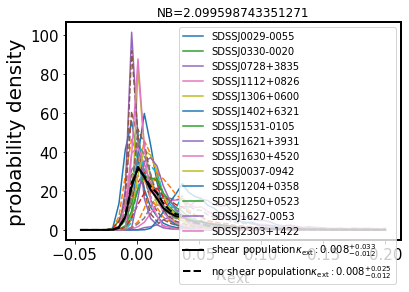

In [11]:

# loop through selected lenses
kappa_pdf_shear = np.zeros(len(kappa_bins)-1)
kappa_pdf_no_shear = np.zeros(len(kappa_bins)-1)
num_shear_lenses = 0

for name in names_selected:
    filepath_shear = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_shear_ending)
    filepath_no_shear = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_no_shear_ending)
 
    try:
        output = np.loadtxt(filepath_shear, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
        kappa_pdf_shear += kappa_pdf
        plt.plot(kappa_bin_edges[1:], kappa_pdf, '-', label=name)
        
        output = np.loadtxt(filepath_no_shear, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
        kappa_pdf_no_shear += kappa_pdf
        plt.plot(kappa_bin_edges[1:], kappa_pdf, '--')
        num_shear_lenses += 1

    except:
        pass
        #print('lens %s does not have a file %s' % (name, filepath))

def kappa_dist_string(name):
    """
    reads out the distribution of a specific lens and returns median and 1-sigma percentiles of distribution
    """
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_no_shear_ending)
    output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
    kappa_sample = output[:, 0]
    kappa_weights = output[:, 1]
    kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
    pdf_shear = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf)
    kappa_samples = pdf_shear.draw(n=100000)
    pcs = np.percentile(kappa_samples, q=percentiles)
    txt = title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
    return txt
    

        
pdf_shear = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_shear/num_shear_lenses)
kappa_samples_shear = pdf_shear.draw(n=100000)
pcs = np.percentile(kappa_samples_shear, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
plt.plot(kappa_bin_edges[1:], kappa_pdf_shear/num_shear_lenses, '-k', linewidth=2, label='shear population' + txt)

pdf_no_shear = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_no_shear/num_shear_lenses)
kappa_samples_no_shear = pdf_no_shear.draw(n=100000)
pcs = np.percentile(kappa_samples_no_shear, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
plt.plot(kappa_bin_edges[1:], kappa_pdf_no_shear/num_shear_lenses, '--k', linewidth=2, label='no shear population' + txt)



plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.title('NB='+str(NoverRmed_max))
plt.legend()
plt.show()

In [12]:
# create latex table
fmt3 = "{{0:{0}}}".format(".3f").format
fmt2 = "{{0:{0}}}".format(".2f").format
fmt0 = "{{0:{0}}}".format(".0f").format

title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
next_string = ' & '

def latex_table(selected_names, ifu_names):
    #print('name  & $z_{\rm lens}$ & $z_{\rm source}$ & $\theta_{\rm E}$ [arcsec] & $r_{\rm eff}$ [arcsec] & $\gamma_{\rm pl}$ & $\zeta_{1/r}$ & $\sigma_{\rm SDSS}$[km/s] & IFU \\')

    with open(file_name_slacs, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            name = row['name']
            if name in selected_names:
                theta_E = fmt3(float(row['theta_E']))
                theta_E_error = fmt3(float(row['theta_E_error']))
                theta_E_string = str(theta_E) + '$\pm$' + str(theta_E_error)
                nR_med = fmt2(NoverRmed(name))
                kappa_string = kappa_dist_string(name)
                
                try:
                    gamma = fmt2(float(row['gamma']))
                    gamma_error = fmt2(float(row['gamma_error']))
                    gamma_string = str(gamma) + '$\pm$' + str(gamma_error)
                except:
                    gamma_string = '-'
                sigma_v, sigma_v_error = vel_disp(name, row)
                sigma_v_string = str(fmt0(sigma_v)) + '$\pm$' + str(fmt0(sigma_v_error))
                z_lens = float(row['z_lens'])
                z_source = float(row['z_source'])
                r_eff = fmt3(float(row['r_eff']))
                r_eff_error = fmt3(float(row['r_eff_error']))
                r_eff_string = str(r_eff) + '$\pm$' + str(r_eff_error)
                if name in ifu_names:
                    ifu_string = 'yes'
                else:
                    ifu_string = 'no'
                print(name,'&', z_lens,'&', z_source, '&', theta_E_string,'&', r_eff_string,'&', gamma_string,'&', nR_med,'&', kappa_string, '&', sigma_v_string, '&', ifu_string, '\\\ ')

latex_table(slacs_slit_names_all+slacs_ifu_names_all, slacs_ifu_names_all)


# zeta 1/r
# kappa_ext


SDSSJ0008-0004 & 0.44 & 1.192 & 1.159$\pm$0.020 & 1.710$\pm$0.060 & - & 1.47 & ${0.019}_{-0.021}^{+0.040}$ & 228$\pm$27 & no \\ 
SDSSJ0029-0055 & 0.227 & 0.931 & 0.951$\pm$0.004 & 2.160$\pm$0.076 & 2.46$\pm$0.10 & 1.14 & ${-0.002}_{-0.008}^{+0.014}$ & 216$\pm$15 & no \\ 
SDSSJ0037-0942 & 0.195 & 0.632 & 1.503$\pm$0.017 & 1.800$\pm$0.063 & 2.19$\pm$0.04 & 1.60 & ${0.012}_{-0.010}^{+0.020}$ & 265$\pm$8 & yes \\ 
SDSSJ0044+0113 & 0.12 & 0.197 & 0.795$\pm$0.020 & 1.920$\pm$0.067 & - & 1.68 & ${-0.001}_{-0.002}^{+0.005}$ & 267$\pm$9 & no \\ 
SDSSJ0216-0813 & 0.3317 & 0.5235 & 1.160$\pm$0.020 & 2.970$\pm$0.200 & - & 0.83 & ${-0.005}_{-0.003}^{+0.005}$ & 351$\pm$19 & yes \\ 
SDSSJ0330-0020 & 0.351 & 1.071 & 1.079$\pm$0.012 & 0.910$\pm$0.032 & 2.16$\pm$0.03 & 1.32 & ${0.006}_{-0.013}^{+0.021}$ & 273$\pm$23 & no \\ 
SDSSJ0728+3835 & 0.206 & 0.688 & 1.282$\pm$0.006 & 1.780$\pm$0.062 & 2.23$\pm$0.06 & 1.12 & ${-0.002}_{-0.006}^{+0.012}$ & 210$\pm$8 & no \\ 
SDSSJ0912+0029 & 0.164 & 0.324 & 1.627$